# [Project Title - Group ID: 27]

Group Members:

Mehmet Efe Kisaaga

Beyda Rojin Boran


## Introduction

<font color="blue" size="3">
In this project, we explore Airbnb and New York City related data and try to find correlations to reveal the main features that might have an effect on customers' decisions when they rent a house from Airbnb. By using these features and properties of listings we are going to try to predict listing prices. As a result, our findings may help both costumers and hosts in terms of features to pay attention and prices to decide on.
</font>


### Problem Definition

<font color="blue" size="3">
What are the significant factors that have a role in costumers' Airbnb decisions? How these factors related to listings? By using these parameters how price varies? Our goal is to reach results that can be helpful for Airbnb hosts while pricing their place and also for customers to choosing a place. In order to achieve this, we will analyze the data, use hypothesis testing and machine learning models, and examine the relations between parameters
</font>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

path_prefix = "/content/drive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from scipy import stats
import re
from collections import Counter
from geopy.distance import geodesic
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from os.path import join

%matplotlib inline

##Utilized Datasets and Data Exploration

Each dataset are separated for a better understanding and can be found below with explanation.

###Exploration of Airbnb Data
This is the main data that we will work on. The other datasets will be compared with this dataset while examining a factor's effect. This data set includes host information, location, room type, price, availability and number of reviews of each airbnb listing in New York.

For the data set please visit: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [ ]:
fname = "AB_NYC_2019.csv"
df = pd.read_csv(join(path_prefix, fname))

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [ ]:
df.isna().sum()*100/df.shape[0]

id                                0.00
name                              0.03
host_id                           0.00
host_name                         0.04
neighbourhood_group               0.00
neighbourhood                     0.00
latitude                          0.00
longitude                         0.00
room_type                         0.00
price                             0.00
minimum_nights                    0.00
number_of_reviews                 0.00
last_review                      20.56
reviews_per_month                20.56
calculated_host_listings_count    0.00
availability_365                  0.00
dtype: float64

We did not drop the NA values because the columns that contain NA values are the columns that we will not deal with. For this reason, dropping that columns are not necessary since we don't want to lose data.

In [ ]:
print("No. of Rows:", df.shape[0], "\tNo. of Columns:", df.shape[1])

No. of Rows: 48895 	No. of Columns: 16


In [ ]:
pd.options.display.float_format = "{:.2f}".format
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,38843.00,48895.00,48895.00
mean,19017143.24,67620010.65,40.73,-73.95,152.72,7.03,23.27,1.37,7.14,112.78
std,10983108.39,78610967.03,0.05,0.05,240.15,20.51,44.55,1.68,32.95,131.62
min,2539.00,2438.00,40.50,-74.24,0.00,1.00,0.00,0.01,1.00,0.00
25%,9471945.00,7822033.00,40.69,-73.98,69.00,1.00,1.00,0.19,1.00,0.00
50%,19677284.00,30793816.00,40.72,-73.96,106.00,3.00,5.00,0.72,1.00,45.00
75%,29152178.50,107434423.00,40.76,-73.94,175.00,5.00,24.00,2.02,2.00,227.00
max,36487245.00,274321313.00,40.91,-73.71,10000.00,1250.00,629.00,58.50,327.00,365.00


####Cleaning the data
Price column has zeros in some rows which is not reasonable. Similarly, availability_365 column has zeros which means they are not available any day of the year. Therefore, we drop that rows.

In [ ]:
df = df[df.price != 0]
df = df[df.availability_365 != 0]
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.135400e+04,3.135400e+04,31354.000000,31354.000000,31354.000000,31354.000000,31354.000000,26147.000000,31354.000000,31354.000000
mean,2.100493e+07,8.145071e+07,40.728406,-73.948753,162.091822,8.338426,31.849365,1.810063,10.335460,175.834439
std,1.148777e+07,8.673941e+07,0.056562,0.051400,254.444750,23.838961,51.638559,1.805657,40.705488,126.195374
min,2.539000e+03,2.571000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,1.000000
25%,1.167354e+07,8.619004e+06,40.688393,-73.983280,70.000000,2.000000,2.000000,0.450000,1.000000,55.000000
50%,2.255750e+07,4.108975e+07,40.723725,-73.954115,112.000000,3.000000,10.000000,1.230000,1.000000,168.000000
75%,3.119452e+07,1.452368e+08,40.763038,-73.930152,189.000000,5.000000,39.000000,2.680000,3.000000,305.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


####Visualization of Neighborhood Groups*

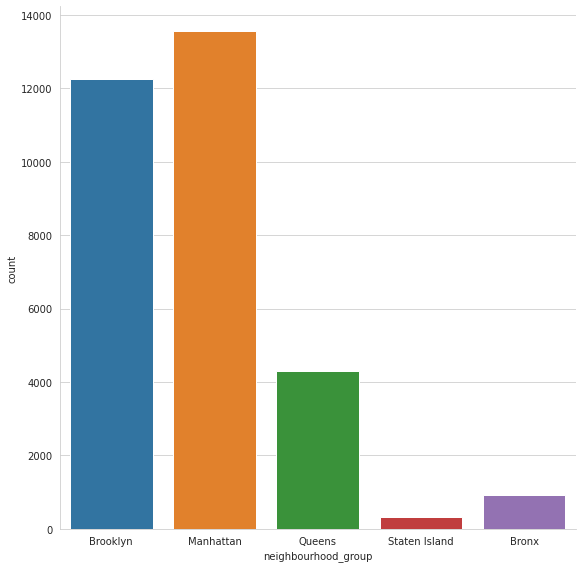

In [ ]:
sns.set_style("whitegrid")
sns.catplot("neighbourhood_group", data=df, kind="count", height=8)

Here, we see that most of the Airbnbs are placed in Manhattan and Brooklyn.

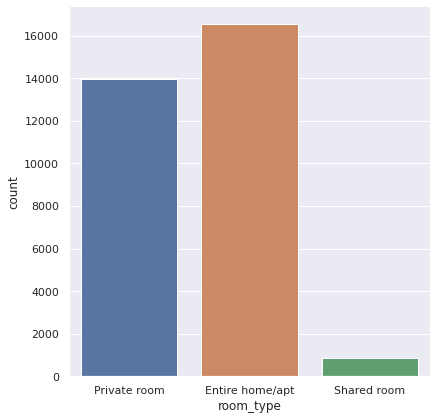

In [ ]:
sns.set(font_scale=1)
sns.catplot("room_type", data=df, kind="count", height=6)

####Visualization of Price Data

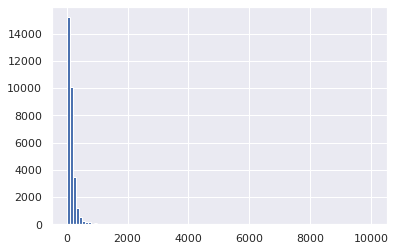

In [ ]:
plt.hist(df["price"], bins=100, range=(df["price"].min(), df["price"].max()))
plt.show()

We can see that there are extreme values in the price column. Most of the price data have values lower than 1000. For this reason, we will look for outliers.

####Outliers

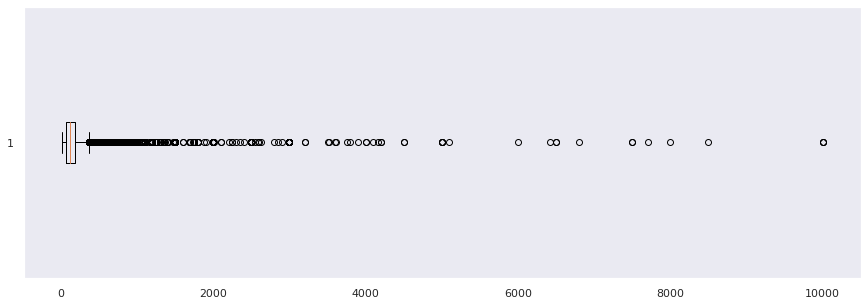

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.boxplot(df["price"], vert=False)
ax.grid()
plt.show()

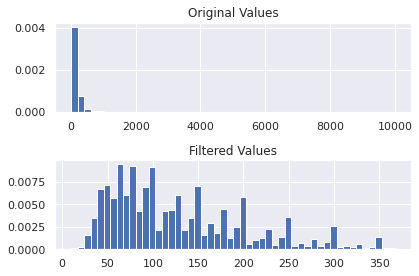

In [ ]:
prices = df["price"].values
q3 = np.percentile(prices, 75)
q1 = np.percentile(prices, 25)
iqr = q3-q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

remaining_values = df[(df["price"] > lower_bound) & (df["price"] < upper_bound)]["price"].values
original_values = df["price"].values

fig, axes = plt.subplots(2, 1)
axes[0].hist(original_values, density=True, bins=50)
axes[1].hist(remaining_values, density=True, bins=50)

axes[0].set_title("Original Values")
axes[1].set_title("Filtered Values")

plt.tight_layout()
plt.show()

As it can be seen, it is more reasonable to work with filtered values in machine learning models to get accurate results.

####Heatmap of Airbnb Locations*

In [ ]:
locs = df[["latitude", "longitude"]].values
m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=10, width=1000, height=500, tiles = "Stamen Terrain",)
# feed it to heatmap function
HeatMap(locs, radius=8, gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)

m

####Choropleth Map of Airbnb Prices

In [ ]:
df_price = df[df["price"] < 1000][["neighbourhood","price"]]
df_price = df_price.groupby("neighbourhood", as_index=False).mean()
df_price.head()

,neighbourhood,price
0,Allerton,91.70
1,Arden Heights,76.00
2,Arrochar,115.00
3,Arverne,156.69
4,Astoria,104.84


In [ ]:
#state_geo = f'https://raw.githubusercontent.com/veltman/snd3/master/data/nyc-neighborhoods.geo.json'
state_geo = f'/content/drive/My Drive/neighbourhoods.geojson'


bins = list(df_price['price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))

m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=10)

choropleth = folium.Choropleth(
    geo_data = state_geo,
    data=df_price,
    columns=['neighbourhood', 'price'],
    key_on='properties.neighbourhood',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Avg. Prices by Neighbourhoods',
    bins=bins,
    reset = True
).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighbourhood'])
)

folium.LayerControl().add_to(m)
m

From this map, customers can see prices of the neighbourhoods and decide according to their budgets.

####Hypotesis Testing on Price and Availability
In the dataset, some Airbnbs are available all of the year and some are not. Does availibility affect the price? Let's see is there any relationship between availibility and price of the Airbnb place.

$ H_0: $ There is no relationship between price and availability

$ H_1: $ There is a relationship between price and availability


In [ ]:
stats.pearsonr(df["price"], df["availability_365"])

(0.07450528637028284, 7.628215144580793e-40)

Since the correlation coefficient (0.07) is close to zero, we can say that there is no significant (almost no) correlation between price and availibility.

###Exploration of Reviews Data
This data set includes customers' reviews on New York City Airbnb listings. Our aim is to find out the most common words that occur in customers' comments since those words are the indicator of what customers care and Airbnb's preferability. It is important for Airbnb hosts to see customers' thoughts about the place after their accomodation to improve the quality of the place. It is also important for the customers to see previous customers' comments because these comments reflect other customers' experiences during the accomodation.

For the data set please visit: http://insideairbnb.com/get-the-data.html


In [ ]:
fname = "reviews.csv"
df_reviews = pd.read_csv(join(path_prefix, fname))

df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2060,158,2008-09-22,2865,Thom,"very nice neighborhood,close enough to ""A"" tra..."
1,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
2,2595,19176,2009-12-05,53267,Cate,Great experience.
3,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
4,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."


In [ ]:
df_reviews.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [ ]:
df_reviews["date"] = pd.to_datetime(df_reviews["date"])
df_reviews.dtypes

listing_id                int64
id                        int64
date             datetime64[ns]
reviewer_id               int64
reviewer_name            object
comments                 object
dtype: object

In [ ]:
df_reviews.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name     10
comments         749
dtype: int64

In this data set, the most important thing that we will look is comments. Therefore, dropping the NaN values is helpful since we need comments.

In [ ]:
df_reviews = df_reviews.dropna(how="any")
df_reviews.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

####Cleaning the data

In [ ]:
df_reviews = df_reviews.drop(columns=["reviewer_id", "reviewer_name"])

Customers' information (i.e., name, and reviewer_id) is not necessary for our future steps, we can drop that columns.


In [ ]:
start = "2019-01-01"
end = "2020-01-01"
start_date = pd.to_datetime(start)
end_date = pd.to_datetime(end)

df_reviews = df_reviews[(start_date < df_reviews["date"]) & (df_reviews["date"] < end_date)]
df_reviews.head()

,listing_id,id,date,comments
43,2595,366477703,2019-01-02,The apartment met expectations to how it was i...
44,2595,449815873,2019-05-07,10 / 10 would stay again
45,2595,456489109,2019-05-21,Place was so cute and comfy! Host was great an...
46,2595,487972917,2019-07-14,I'm glad I stayed here. I liked everything.\nT...
47,2595,514642186,2019-08-21,"First of all I have to say, that Jennifer is n..."


We also narrow the date of the reviews because our main dataset (Airbnb) includes 2019 listings.

Now let's see what are the most common words. Some words in English such as "the" , "as" , "and" are removed because they are most common used words in English but they are not we are looking for.

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

comments = []
for comment in df_reviews.comments:
  comments.append(comment)

def split_name(name):
  spl=str(name).split()
  return spl

punc = ["!", "/", "<", "\.", ",", "'", "\n", "-"]

words = []
for comment in comments:
  for a in range(len(punc)):
    comment = re.sub(punc[a], " ", comment)
  for word in split_name(comment):
        word=word.lower()
        words.append(word)

top_100_words = Counter(words).most_common()

stop_words = set(stopwords.words("english"))

filtered_words = [w for w in words if not w in stop_words]
filtered_words[:100]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['apartment',
 'met',
 'expectations',
 'insinuated',
 'ad',
 'jennifer',
 'welcoming',
 'friendly',
 'little',
 'pricey',
 '500',
 'sq',
 'ft',
 'space',
 'convenient',
 'location',
 'want',
 'walk',
 '4',
 'story',
 'stair',
 'case',
 'already',
 'long',
 'day',
 'walking',
 'place',
 '10',
 '10',
 'would',
 'stay',
 'place',
 'cute',
 'comfy',
 'host',
 'great',
 'quick',
 'communicate',
 'questions',
 'quick',
 'walk',
 'subway',
 '5',
 'min',
 'walk',
 'empire',
 'state',
 'building',
 'overall',
 'great',
 'stay',
 'host',
 'amazing',
 'glad',
 'stayed',
 'liked',
 'everything',
 'apartment',
 'quite',
 'spacious',
 'comfortable',
 'extraordinary',
 'glass',
 'roof',
 'beautiful',
 'reflection',
 'empire',
 'state',
 'building',
 'seen',
 'window',
 'excellent',
 'location',
 'center',
 'manhattan',
 'minutes',
 'walk',
 'excellent',
 'bryant',
 'park',
 'whole',
 'foods',
 'market',
 'jeniffer',
 'friendly',
 'last',
 'day',
 'flight',
 'delayed',
 'late',
 'check',
 'appreciate

As it can be seen above, we may say that customers care about closeness to the subway station since one of the most common words is "subway", or closeness to the touristic places since three of the most common words are "empire state building", and location, the comfort of the place. An Airbnb owner can improve their place, or a person who is planning to host an Airbnb can consider these words for getting more customers.

###Exploration of Crime Data
This dataset includes all valid crimes reported to the New York City Police Department (NYPD) for 2019. We will use this data to determine if customers consider safety of the areas that they're planning to stay.

For the data set please visit: https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243/data

In [ ]:
fname = "NYPD_Complaint_Data_Current__Year_To_Date_.csv"
df_crime = pd.read_csv(join(path_prefix, fname))

df_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,12/30/2019,20:30:00,12/31/2019,10:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,12/24/2019,16:55:00,12/24/2019,17:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,12/30/2019,19:32:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,12/30/2019,15:30:00,12/30/2019,16:50:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"


In [ ]:
df_crime.dtypes

CMPLNT_NUM             int64
ADDR_PCT_CD            int64
BORO_NM               object
CMPLNT_FR_DT          object
CMPLNT_FR_TM          object
CMPLNT_TO_DT          object
CMPLNT_TO_TM          object
CRM_ATPT_CPTD_CD      object
HADEVELOPT            object
HOUSING_PSA          float64
JURISDICTION_CODE    float64
JURIS_DESC            object
KY_CD                  int64
LAW_CAT_CD            object
LOC_OF_OCCUR_DESC     object
OFNS_DESC             object
PARKS_NM              object
PATROL_BORO           object
PD_CD                float64
PD_DESC               object
PREM_TYP_DESC         object
RPT_DT                object
STATION_NAME          object
SUSP_AGE_GROUP        object
SUSP_RACE             object
SUSP_SEX              object
TRANSIT_DISTRICT     float64
VIC_AGE_GROUP         object
VIC_RACE              object
VIC_SEX               object
X_COORD_CD             int64
Y_COORD_CD             int64
Latitude             float64
Longitude            float64
Lat_Lon       

We dropped the columns we dont need.

In [ ]:
df_crime = df_crime[["BORO_NM","CMPLNT_FR_DT","Latitude","Longitude","Lat_Lon"]]
df_crime

,BORO_NM,CMPLNT_FR_DT,Latitude,Longitude,Lat_Lon
0,BRONX,12/31/2019,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
1,MANHATTAN,12/30/2019,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
2,BROOKLYN,12/24/2019,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
3,BRONX,12/30/2019,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
4,MANHATTAN,12/30/2019,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"
...,...,...,...,...,...
461706,BROOKLYN,01/03/2019,40.669126,-73.905708,"(40.66912567900005, -73.90570750399996)"
461707,QUEENS,01/02/2019,40.692214,-73.733559,"(40.692213915000025, -73.73355857399997)"
461708,BROOKLYN,01/05/2019,40.609900,-73.922373,"(40.60990012500002, -73.92237286099999)"
461709,MANHATTAN,01/04/2019,40.756642,-73.988372,"(40.75664204200007, -73.98837157699995)"


In [ ]:
df_crime.isna().sum()

BORO_NM         326
CMPLNT_FR_DT      0
Latitude          0
Longitude         0
Lat_Lon           0
dtype: int64

As it can be seen, the NaN values are in the BORO_NM column which indicates the region of the crime. Since we are dealing with the regions, dropping those NaN values is helpful.

In [ ]:
df_crime = df_crime.dropna(how="any")
df_crime.isna().sum()

BORO_NM         0
CMPLNT_FR_DT    0
Latitude        0
Longitude       0
Lat_Lon         0
dtype: int64

####Visualization of Regions and the Number of Complaints

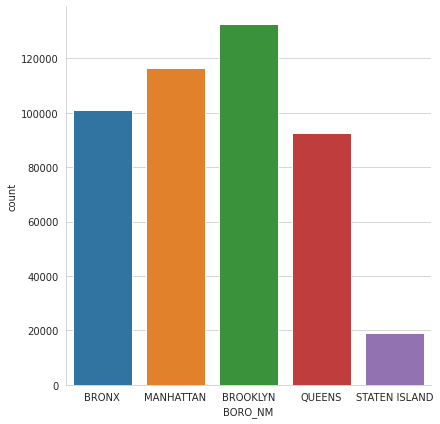

In [ ]:
sns.set_style("whitegrid")
sns.catplot("BORO_NM", data=df_crime, kind="count", height=6)

Comparing these numbers with the number of Airbnbs in these areas, in the first look, we may say that there is no relation for Staten Island but for the other regions we need to examine it more detailed.

In [ ]:
state_geo = f'/content/drive/My Drive/neighbourhoods.geojson'
df_sample_crime = df_crime[["CMPLNT_FR_DT"]]
locs = df_crime[["Latitude", "Longitude"]].values
m = folium.Map(location=[df_crime["Latitude"].mean(), df_crime["Longitude"].mean()], zoom_start=10, width=1000, height=500, tiles = "Stamen Terrain",)
# feed it to heatmap function
HeatMap(locs, radius=8).add_to(m)
choropleth = folium.Choropleth(
    geo_data = state_geo,
    fill_opacity=0
).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighbourhood'])
)

df_price_ind = df.sort_values(by="price", ascending=False)
df_price_top = df_price_ind.iloc[:100,:]
df_price_last = df_price_ind.iloc[-100:,:]

temp = df_price_top[["latitude", "longitude"]].values
coors = np.unique(temp, axis = 0)
#bunu calistiramadim ama subway entrance gibi dairelerden ekleyelim airbnb yerleri icin
for i in coors:
  folium.CircleMarker(location=i, color="blue", radius = 1).add_to(m)

temp = df_price_last[["latitude", "longitude"]].values
coors = np.unique(temp, axis = 0)
#bunu calistiramadim ama subway entrance gibi dairelerden ekleyelim airbnb yerleri icin
for i in coors:
  folium.CircleMarker(location=i, color="red", radius = 1).add_to(m)


folium.LayerControl().add_to(m)
m


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
neighbourhoods = df["neighbourhood"]
top_neighbourhoods = Counter(neighbourhoods).most_common()
top_neighbourhoods[:15]

[('Bedford-Stuyvesant', 2478),
 ('Williamsburg', 2051),
 ('Harlem', 1734),
 ('Bushwick', 1447),
 ("Hell's Kitchen", 1446),
 ('Upper East Side', 1095),
 ('Upper West Side', 1089),
 ('Midtown', 1087),
 ('East Village', 957),
 ('Crown Heights', 912),
 ('East Harlem', 736),
 ('Chelsea', 706),
 ('Greenpoint', 585),
 ('Financial District', 572),
 ('Washington Heights', 548)]

Here, we take 100 most expensive and 100 cheapest Airbnbs since it is hard to show 30.000 Airbnb on this map. The blue circles represent the most expensive ones and red circles represent the cheapest ones. As we can see, even in the places where the crimes are happening mostly, the most expensive and/or the least expensive Airbnbs can take place. Furthermore, when we look at the top 15 neighborhoods in terms of their number of Airbnbs, again it is not affected by the crimes. For example, Bedford-Stuyvesant and Williamsburg are the top 2 neighborhoods that have a high number of Airbnbs. However, from the heatmap, we can see that these are also some of the places where crimes are often seen. Therefore, we cannot conclude that crimes affect prices or the location of Airbnbs. However, this map can help customers to choose the safest neighborhoods such as Rossville and Prince's Bay if they have concerns about safety.

###Exploration of NYC Subway Entrance Data
This data set includes names, lines and locations of NYC subway entrances. We will use this data in order to see if there is any relation between subway entrances and airbnb preferences.

For the data set please visit: https://data.cityofnewyork.us/Transportation/Subway-Entrances/drex-xx56

In [ ]:
#DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv
fname = "DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv"
df_subway = pd.read_csv(join(path_prefix, fname))

df_subway.head()

,OBJECTID,URL,NAME,the_geom,LINE
0,1734,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NW corner,POINT (-73.86835600032798 40.84916900104506),2-5
1,1735,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NE corner,POINT (-73.86821300022677 40.84912800131844),2-5
2,1736,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.87349900050798 40.84122300105249),2-5
3,1737,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.8728919997833 40.84145300067447),2-5
4,1738,http://web.mta.info/nyct/service/,Boston Rd & 178th St at SW corner,POINT (-73.87962300013866 40.84081500075867),2-5


In [ ]:
df_subway.dtypes

OBJECTID     int64
URL         object
NAME        object
the_geom    object
LINE        object
dtype: object

In [ ]:
df_subway.isna().sum()

OBJECTID     0
URL          0
NAME        29
the_geom     0
LINE         0
dtype: int64

####Creating Latitude and Longitude Columns
In this data set, the latitude and longitude columns are not in the format as that we want. Therefore, we create new columns as we want.

In [ ]:
def findLon(the_geom):
  the_geom = the_geom[7:-1]
  coor = the_geom.split(" ")
  return float(coor[0])

def findLat(the_geom):
  the_geom = the_geom[7:-1]
  coor = the_geom.split(" ")
  return float(coor[1])

df_subway["Latitude"] = df_subway["the_geom"].apply(findLat)
df_subway["Longitude"] = df_subway["the_geom"].apply(findLon)
df_subway.head()


,OBJECTID,URL,NAME,the_geom,LINE,Latitude,Longitude
0,1734,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NW corner,POINT (-73.86835600032798 40.84916900104506),2-5,40.849169,-73.868356
1,1735,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NE corner,POINT (-73.86821300022677 40.84912800131844),2-5,40.849128,-73.868213
2,1736,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.87349900050798 40.84122300105249),2-5,40.841223,-73.873499
3,1737,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.8728919997833 40.84145300067447),2-5,40.841453,-73.872892
4,1738,http://web.mta.info/nyct/service/,Boston Rd & 178th St at SW corner,POINT (-73.87962300013866 40.84081500075867),2-5,40.840815,-73.879623


In [ ]:
df_subway.dtypes

OBJECTID       int64
URL           object
NAME          object
the_geom      object
LINE          object
Latitude     float64
Longitude    float64
dtype: object

####Visualization of Subway Entrances on the map

In [ ]:
temp = df_subway[["Latitude", "Longitude"]].values
coors = np.unique(temp, axis = 0)

In [ ]:
m = folium.Map(location=[df_subway["Latitude"].mean(), df_subway["Longitude"].mean()], zoom_start=11, tiles = "Stamen Terrain")

locs_airbnb = df[["latitude", "longitude"]].values

HeatMap(locs_airbnb, radius=12).add_to(m)

for i in coors:
  folium.CircleMarker(location=i, color="blue", radius = 1).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

It seems like there is a relation between subway entrances and airbnb counts. Let's calculate each of airbnbs closeness to nearest subway entrance.

In [ ]:
def distToSubway(row):
  host_lon = row["longitude"]
  host_lat = row["latitude"]
  min_dist = float('inf')
  for station in df_subway.values:
    sta_lon = station[6]
    sta_lat = station[5]
    dist_geo = geodesic((sta_lat, sta_lon), (host_lat, host_lon)).km
    dist_flt = float(dist_geo)
    if dist_flt < min_dist:
      min_dist = dist_flt
  return min_dist


In [ ]:
df_w_dist = df.copy()
#df_initial = df_initial.iloc[:10,:]
df_w_dist.shape

(31354, 16)

In [ ]:
df_w_dist["distance"] = df_w_dist.apply(distToSubway, axis=1)
df_w_dist.head()

In [ ]:
df_w_dist.to_csv('data_with_dist.csv')
!cp data_with_dist.csv "drive/My Drive/"

It took almost 3 hours to run calculation function so we saved the result as a csv file and we will open it when we need it.

In [ ]:
fname = "data_with_dist.csv"
df_d = pd.read_csv(join(path_prefix, fname))

df_d.head()

,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,0.392194
1,1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0.085603
2,2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0.308334
3,3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,0.402859
4,5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,0.353309


####Hypothesis Testing on Subway Distances and Price
As we see in the map, there are more airbnbs near the subway entrances. So, we are going to test the hypothesis that if closeness of airbnbs to subway entrances affect the prices.

$ H_0: $ There is not relationship between price and closeness of airbnbs to subway entrances

$ H_1: $ There is a relationship between price and closeness of airbnbs to subway entrances


In [ ]:
stats.pearsonr(df_d["price"], df_d["distance"])

(-0.05888112826448279, 1.7205710819491938e-25)

Since the correlation coefficient (-0.058) is close to zero, we can say that there is no significant (almost no) correlation between price and closeness of airbnbs to subway entrances.

##Machine Learning Models
We are going to apply three different machine learning model for price prediction.

###Getting Data Prepared for Models

In [ ]:
df_d.columns

Index(['Unnamed: 0', 'id', 'name', 'host_id', 'host_name',
       'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'distance'],
      dtype='object')

We drop the unnecessary columns.

In [ ]:
model_df = df_d.copy()
model_df = model_df.drop(["Unnamed: 0", "id", "name", "host_id", "host_name", "last_review"], axis=1)
model_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,0.392194
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,0.085603
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365,0.308334
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,0.402859
4,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129,0.353309


In [ ]:
model_df.isna().sum()*100/model_df.shape[0]

neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
reviews_per_month                 16.607131
calculated_host_listings_count     0.000000
availability_365                   0.000000
distance                           0.000000
dtype: float64

In [ ]:
model_df["reviews_per_month"].fillna(0, inplace=True)
model_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,0.392194
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,0.085603
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0.308334
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,0.402859
4,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129,0.353309


####Label Encoding
We need to convert categorical values to numerical values in order to use in our models.

In [ ]:
le = preprocessing.LabelEncoder()                                            # Fit label encoder
le.fit(model_df['neighbourhood_group'])
model_df['neighbourhood_group']=le.transform(model_df['neighbourhood_group'])    # Transform labels to normalized encoding.

le = preprocessing.LabelEncoder()
le.fit(model_df['neighbourhood'])
model_df['neighbourhood']=le.transform(model_df['neighbourhood'])

le = preprocessing.LabelEncoder()
le.fit(model_df['room_type'])
model_df['room_type']=le.transform(model_df['room_type'])

model_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,1,107,40.64749,-73.97237,1,149,1,9,0.21,6,365,0.392194
1,2,126,40.75362,-73.98377,0,225,1,45,0.38,2,355,0.085603
2,2,93,40.80902,-73.94190,1,150,3,0,0.00,1,365,0.308334
3,1,40,40.68514,-73.95976,0,89,1,270,4.64,1,194,0.402859
4,2,136,40.74767,-73.97500,0,200,3,74,0.59,1,129,0.353309


In [ ]:
model_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,1,107,40.64749,-73.97237,1,149,1,9,0.21,6,365,0.392194
1,2,126,40.75362,-73.98377,0,225,1,45,0.38,2,355,0.085603
2,2,93,40.80902,-73.94190,1,150,3,0,0.00,1,365,0.308334
3,1,40,40.68514,-73.95976,0,89,1,270,4.64,1,194,0.402859
4,2,136,40.74767,-73.97500,0,200,3,74,0.59,1,129,0.353309


In order to get better results, we eleminated the outliers in price column. Because they can result in extreme values.

In [ ]:
prices = model_df["price"].values
q3 = np.percentile(prices, 75)
q1 = np.percentile(prices, 25)
iqr = q3-q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

remaining_vals= model_df[(model_df["price"] > lower_bound) & (model_df["price"] < upper_bound)]["price"].values
outliers = model_df[(model_df["price"] <= lower_bound) | (model_df["price"] >= upper_bound)]["price"].values
for i in outliers:
  model_df = model_df[model_df["price"] != i]
model_df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,1,107,40.64749,-73.97237,1,149,1,9,0.21,6,365,0.392194
1,2,126,40.75362,-73.98377,0,225,1,45,0.38,2,355,0.085603
2,2,93,40.80902,-73.94190,1,150,3,0,0.00,1,365,0.308334
3,1,40,40.68514,-73.95976,0,89,1,270,4.64,1,194,0.402859
4,2,136,40.74767,-73.97500,0,200,3,74,0.59,1,129,0.353309
...,...,...,...,...,...,...,...,...,...,...,...,...
31349,1,12,40.67853,-73.94995,1,70,2,0,0.00,2,9,0.193928
31350,1,27,40.70184,-73.93317,1,40,4,0,0.00,2,36,0.471693
31351,2,93,40.81475,-73.94867,0,115,10,0,0.00,1,27,0.242752
31352,2,94,40.75751,-73.99112,2,55,1,0,0.00,6,2,0.096069


In [ ]:
model_df.dtypes

neighbourhood_group                 int64
neighbourhood                       int64
latitude                          float64
longitude                         float64
room_type                           int64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
distance                          float64
dtype: object

Even though we get rid of the outliers, the accuracy still will not be much higher. Therefore, we apply logarithmic function.

In [ ]:
model_df["price"] = np.log(model_df["price"] + 1)
model_df.describe()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
count,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000,29493.000000
mean,1.703794,102.684942,40.727963,-73.947168,0.523955,4.677989,8.277727,32.890042,1.541626,9.794290,173.133862,0.445572
std,0.788978,67.328993,0.057413,0.051820,0.554146,0.592858,23.252703,52.505361,1.798422,38.879252,125.947720,0.660202
min,0.000000,0.000000,40.499790,-74.244420,0.000000,2.397895,1.000000,0.000000,0.000000,1.000000,1.000000,0.000891
25%,1.000000,50.000000,40.687670,-73.982040,0.000000,4.248495,2.000000,2.000000,0.190000,1.000000,53.000000,0.173269
50%,2.000000,93.000000,40.722140,-73.952690,0.000000,4.634729,3.000000,11.000000,0.960000,1.000000,162.000000,0.290547
75%,2.000000,164.000000,40.763350,-73.928400,1.000000,5.141664,5.000000,41.000000,2.380000,3.000000,302.000000,0.462539
max,4.000000,217.000000,40.913060,-73.712990,2.000000,5.908083,1250.000000,629.000000,58.500000,327.000000,365.000000,7.933548


In [ ]:
model_df.dtypes

neighbourhood_group                 int64
neighbourhood                       int64
latitude                          float64
longitude                         float64
room_type                           int64
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
distance                          float64
dtype: object

In [ ]:
X = model_df.drop("price", axis=1)
y = model_df["price"].values

In [ ]:
# 80% for training / croos-validation and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

###kNN Model

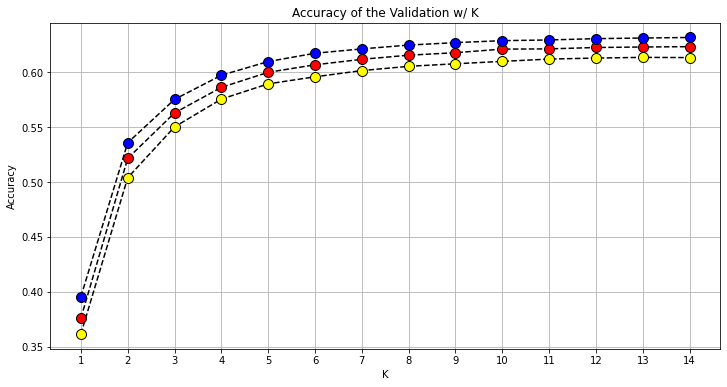

In [ ]:
K_range = np.arange(1, 15)
accuracy_list = []
knn_metric = ["euclidean", "manhattan", "chebyshev"]
colors = ["red", "blue", "yellow"]

plt.figure(figsize=(12, 6))  

for m in range(len(knn_metric)):
  accuracy_list = []
  for k in K_range:
    # create a new model with current K
    knn = KNeighborsRegressor(k, metric=knn_metric[m])
    # fit training data
    knn.fit(X_train, y_train)
    # predict the validation data
    accuracies_CV = cross_val_score(knn, X_train, y_train, cv=5)
    accuracy_list.append(accuracies_CV.mean())
  plt.plot(K_range, accuracy_list, color='black', linestyle='dashed', marker='o',  
         markerfacecolor=colors[m], markersize=10)

plt.title('Accuracy of the Validation w/ K')  
plt.xlabel('K')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
plt.grid()
plt.show()

It seems like while K is increasing, the accuracy score is also increasing up to some point.

MAE (Mean Absolute Error): 0.28050840845772645
MSE (Mean Squared Error): 0.13352078904492198
RMSE (Root mean squared error): 0.3654049658186407
R2 score: 0.6191431724754619
----------------------



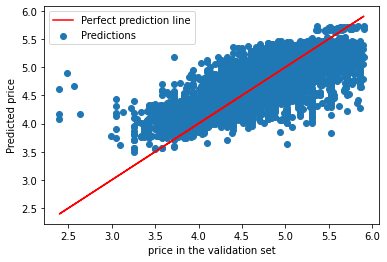

In [ ]:
knn = KNeighborsRegressor(k, metric="manhattan")
# fit training data
knn.fit(X_train, y_train)
# predict the validation data
y_pred = knn.predict(X_test)
  # obtain the accuracy value
r2 = r2_score(y_test, y_pred)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('MAE (Mean Absolute Error): %s' %mae)
print('MSE (Mean Squared Error): %s' %mse)
print('RMSE (Root mean squared error): %s' %rmse)
print('R2 score: %s' %r2)
print('----------------------\n')

plt.scatter(y_test, y_pred, label='Predictions')
plt.plot(y_test,y_test,'r',label='Perfect prediction line')
plt.xlabel("price in the validation set")
plt.ylabel("Predicted price")
plt.legend()

We applied tuning for the parameter metric and n_neighbours -number of neighbours-. While tuning, we didn't use the validation data because we used cross-validation. After we picked the proper k value and best metric, we used model to predict test data. Then, we obtained error rates and r2 score.

###Random Forest Model

[10 20 30 40]


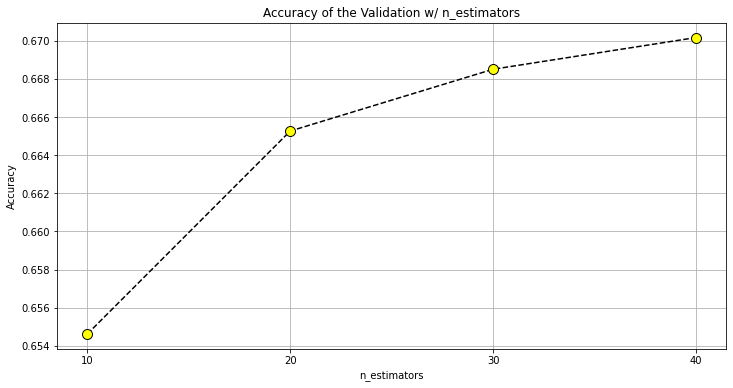

In [ ]:
K_range = np.arange(10, 50, 10)

print(K_range)
accuracy_list = []

plt.figure(figsize=(12, 6))  

for k in K_range:
  # create a new model with current n_estimators
  model_rf = RandomForestRegressor(n_estimators=k, random_state=42, min_samples_leaf=4)
  # fit training data
  model_rf.fit(X_train, y_train)
  
  accuracies_CV = cross_val_score(model_rf, X_train, y_train, cv=5)
  accuracy_list.append(accuracies_CV.mean())


plt.plot(K_range, accuracy_list, color='black', linestyle='dashed', marker='o',  
        markerfacecolor='yellow', markersize=10)
  

plt.title('Accuracy of the Validation w/ n_estimators')  
plt.xlabel('n_estimators')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
plt.grid()
plt.show()

MAE (Mean Absolute Error): 0.2567636287324009
MSE (Mean Squared Error): 0.1165796527790481
RMSE (Root mean squared error): 0.34143762648403014
R2 score: 0.66746633966938
----------------------



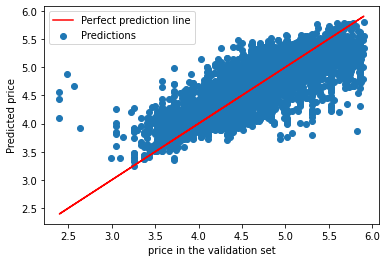

In [ ]:
# create a new model with current K
model_rf = RandomForestRegressor(n_estimators=40, random_state=42, min_samples_leaf=4)
  # fit training data
model_rf.fit(X_train, y_train)
  # predict the validation data
y_pred = model_rf.predict(X_test)
  # obtain the accuracy value
r2 = r2_score(y_test, y_pred)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('MAE (Mean Absolute Error): %s' %mae)
print('MSE (Mean Squared Error): %s' %mse)
print('RMSE (Root mean squared error): %s' %rmse)
print('R2 score: %s' %r2)
print('----------------------\n')

plt.scatter(y_test, y_pred, label='Predictions')
plt.plot(y_test,y_test,'r',label='Perfect prediction line')
plt.xlabel("price in the validation set")
plt.ylabel("Predicted price")
plt.legend()

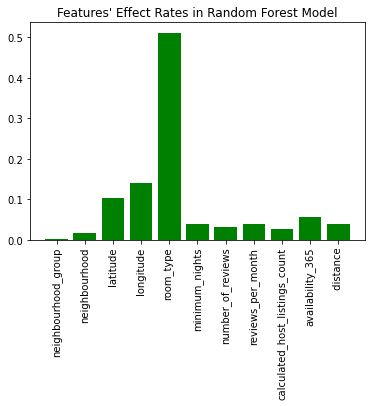

In [ ]:
features = []
for feature in zip(X.columns, model_rf.feature_importances_):
    features.append(feature)

y_feat = []
x_feat = []

for feature in features:
  y_feat.append(feature[1])
  x_feat.append(feature[0])

plt.title("Features' Effect Rates in Random Forest Model")
labels = ["neighbourhood_group", "neighbourhood", "latitude", "longitude", "room_type", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365", " distance"]
x_pos = [i for i, _ in enumerate(labels)]
plt.bar(x_pos, y_feat, color='green')
plt.xticks(x_pos, labels, rotation = "vertical")
plt.show()


From the chart above, we can see that room type has a dominant effect over the other parameters on random forest model.

We applied tuning on n_estimators parameter. After we chose the best value, we calculated error rates and r2 score with test data. Also, we wanted to take a look at how each feature affected random forest modeling, a.k.a feature importances.

###Decision Tree Model

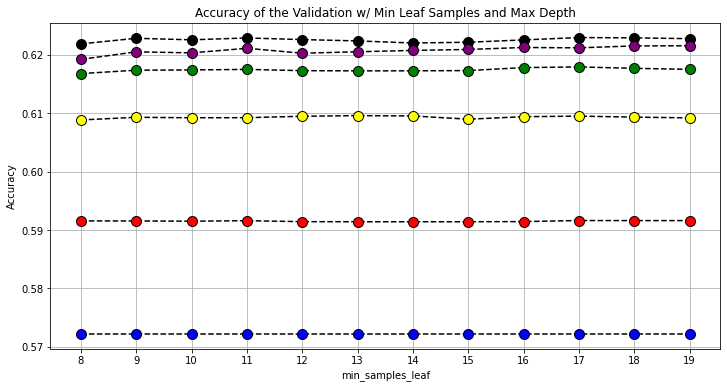

In [ ]:
L_range = np.arange(8, 20) #min samples leaf
D_range = np.arange(4, 10) #max depth
accuracy_list = []
plt.figure(figsize=(12, 6)) 
colors = ['blue', 'red', 'yellow', 'green', 'black', 'purple']

for d in range(len(D_range)):
  accuracy_list = []
  for l in L_range:
    # create a new model with current K
    model_dt = DecisionTreeRegressor(max_depth=D_range[d], min_samples_leaf=l)
    # fit training data
    model_dt.fit(X_train, y_train)
    # predict the validation data
    accuracies_CV = cross_val_score(model_dt, X_train, y_train, cv=5)
    accuracy_list.append(accuracies_CV.mean())

  
  plt.plot(L_range, accuracy_list, color='black', linestyle='dashed', marker='o',  
          markerfacecolor=colors[d], markersize=10)
  

plt.title('Accuracy of the Validation w/ Min Leaf Samples and Max Depth')  
plt.xlabel('min_samples_leaf')  
plt.ylabel('Accuracy')
plt.xticks(L_range)
plt.grid()
plt.show()

MAE (Mean Absolute Error): 0.28054717542619845
MSE (Mean Squared Error): 0.134431669138317
RMSE (Root mean squared error): 0.3666492453808094
R2 score: 0.6165449635740079
----------------------



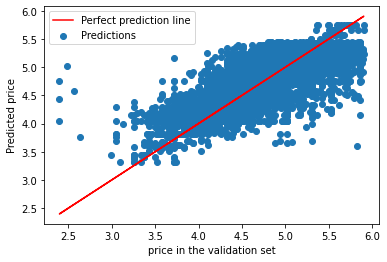

In [ ]:
  # predict the test data
y_pred = model_dt.predict(X_test)
  # obtain the accuracy value
r2 = r2_score(y_test, y_pred)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('MAE (Mean Absolute Error): %s' %mae)
print('MSE (Mean Squared Error): %s' %mse)
print('RMSE (Root mean squared error): %s' %rmse)
print('R2 score: %s' %r2)
print('----------------------\n')

plt.scatter(y_test, y_pred, label='Predictions')
plt.plot(y_test,y_test,'r',label='Perfect prediction line')
plt.xlabel("price in the validation set")
plt.ylabel("Predicted price")
plt.legend()

We applied hyperparameter tuning for max_depth and min_samples_leaf. While tuning, we didn't use the validation data because we used cross-validation. After we picked the proper values, we used model to predict test data. Then, we obtained error rates and r2 score.

###Results & Discussion



|Model | R2 Score | MAE | MSE | RMSE |
| --- | --- | --- | --- | --- |
|kNN | 0.62 | 0.27 | 0.13 | 0.36 |
|Random Forest | 0.66 | 0.25 | 0.11 | 0.34 |
|Decision Tree | 0.61 | 0.28 | 0.13 | 0.36 |

Random Forest is the best of these three models because it has a higher r^2 score, less MAE, less MSE, and less RMSE. Since random forests consist of single decision trees that are randomly selected from train data, it is expectable to has a better accuracy score. kNN and Decision tree are very close to each other in all parameters. However, kNN is computationally more expensive. On the other hand, kNN has less hyperparameter to tune, it has an advantage in random forest and decision tree models in terms of this way. But choosing the value of hyperparameter K is crucial.

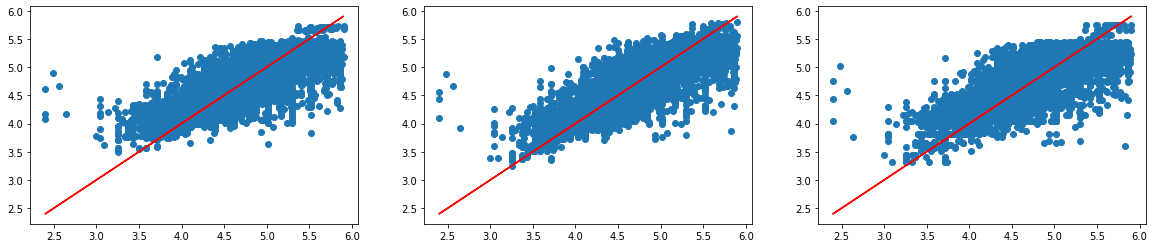

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
models = [knn, model_rf, model_dt]
for x in range(len(ax)):
  y_pred = models[x].predict(X_test)
  ax[x].scatter(y_test, y_pred, label='Predictions')
  ax[x].plot(y_test,y_test,'r',label='Perfect prediction line')

All of these charts are very similar to each other. So there is not a significant difference between them. Even we applied normalization with StandardScaler and logarithmic normalization, skewness of data is still to high.

##Conclusion
Our aim was to reach certain factors that shape price, customer decisions, and effect of these factors on listings so that hosts can increase their income and customers can improve their experience. Although we couldn't come up with clear facts, our findings are as follows:<br>
- As we move to the west side on the map, amount of Airbnb listings increases. Even the alternative listings are increasing, price is increasing too. Especially, Manhattan has higher amounts and higher prices of airbnb listings.<br> 
- We argued availability has an influence on Airbnb prices but our hypothesis testing results didn't support that argument. So there is no relation between price and availabitiy.<br>
- As a result of examination of customer reviews, we have found some specific words that customers emphasized on. Hosts can improve their places by considering that words. As a result, they can get more customer and increase their income. New customers can also benefit from it in order to have a better experience.<br>
- We have already stated our conclusions about crime-related comparisons. So briefly, it doesn't have an effect on the price or Airbnb location. But still, our findings may help to the ones who have some concerns about safety. <br>
- The word "subway" was in the 100 most common words in reviews part. Based on this, and the heat map of Airbnbs with subway entrances, we can say that it is better to have an Airbnb which is close to a subway entrance for a host.<br>
- Lastly, our machine learning application results pointed that we don't have a data including parameters that significantly affecting price variation. Even with the normalizations, we had very skewed graphs. If we had got more proper data to model price, it wouldn't have been like that.<br>

Even though we couldn't reach our expectations, based on these findings above we think that our solution is partially applicable.